In [170]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.legend_handler import HandlerTuple
import matplotlib.lines as mlines

In [158]:
# import float position
float_pos = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/list_of_profiles.csv')
float_pos = float_pos[float_pos['profile'].str.contains('a', na=False)]
float_pos = float_pos[['profile', 'lat', 'lon']]
float_pos.rename(columns={'profile': 'Profile', 'lat': 'Latitude', 'lon':'Longitude'}, inplace=True)
float_pos['Profile_nb'] = range(1, len(float_pos) + 1)
float_pos

,Profile,Latitude,Longitude,Profile_nb
0,0000a_WMO6903095,-33.070000,13.894444,1
1,0001a_WMO6903095,-33.051944,13.943056,2
2,0002a_WMO6903095,-33.040556,14.000833,3
3,0003a_WMO6903095,-33.047778,14.058889,4
4,0004a_WMO6903095,-33.064722,14.103056,5
...,...,...,...,...
179,0179a_WMO6903095,-34.176389,11.428056,180
180,0180a_WMO6903095,-34.191667,11.068056,181
181,0181a_WMO6903095,-34.246944,10.725556,182
182,0182a_WMO6903095,-34.339444,10.433333,183


In [159]:
# Read the bathymetric data from the .asc file

bathymetry_file = '/home/aaccardo/Accardo_et_al/Data/map/bathy_benguela.csv'
bathymetry_data = pd.read_csv(bathymetry_file)
bathymetry_data = bathymetry_data.rename(columns={'x': 'Longitude', 'y' : 'Latitude', 'Latitude':'lat', 'Pressure [dbar]':'Depth [m]'})
print(bathymetry_data)

       Longitude  Latitude            z        Depth
0       3.000000     -31.0 -2190.537354  2190.537354
1       3.066964     -31.0 -3795.837402  3795.837402
2       3.133929     -31.0 -4543.047363  4543.047363
3       3.200893     -31.0 -4822.687500  4822.687500
4       3.267857     -31.0 -4933.297363  4933.297363
...          ...       ...          ...          ...
47218  17.732143     -45.0 -5041.897949  5041.897949
47219  17.799107     -45.0 -4581.657715  4581.657715
47220  17.866071     -45.0 -4271.967773  4271.967773
47221  17.933036     -45.0 -4280.727539  4280.727539
47222  18.000000     -45.0 -4445.057617  4445.057617

[47223 rows x 4 columns]


Number of NaN values in 'Longitude' column: 0


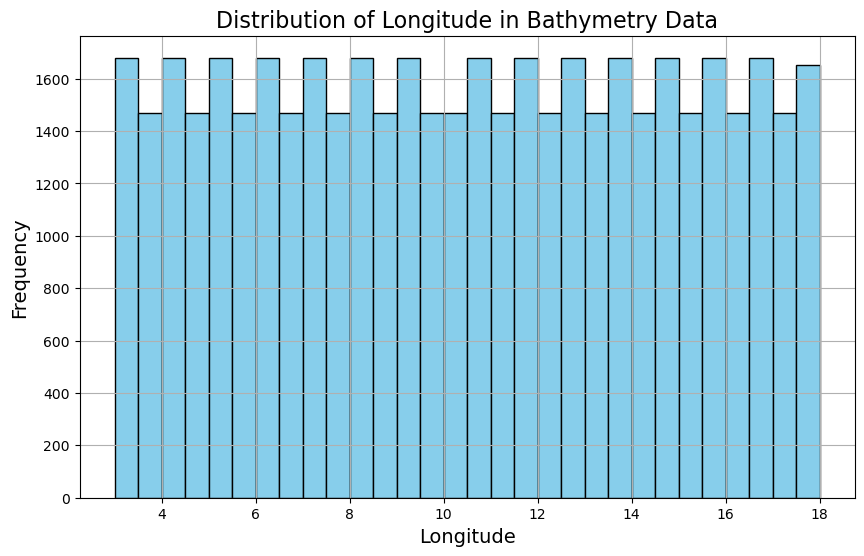

In [160]:
# Create a histogram of the Longitude distribution
nan_count = bathymetry_data['Longitude'].isna().sum()

print(f"Number of NaN values in 'Longitude' column: {nan_count}")
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(bathymetry_data['Longitude'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of Longitude in Bathymetry Data', fontsize=16)

# Show the plot
plt.grid(True)
plt.show()

Number of NaN values in 'Latitude' column: 0


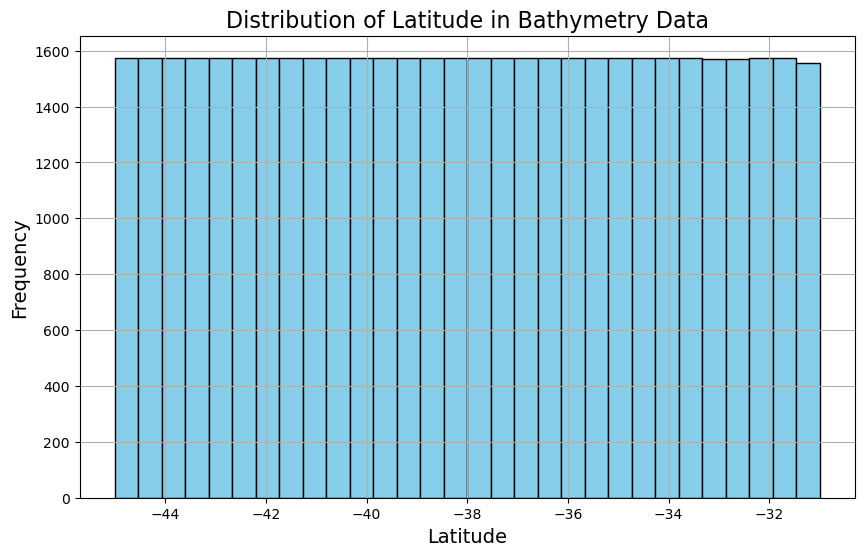

In [161]:
# Create a histogram of the Longitude distribution
nan_count = bathymetry_data['Latitude'].isna().sum()

print(f"Number of NaN values in 'Latitude' column: {nan_count}")
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(bathymetry_data['Latitude'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
ax.set_xlabel('Latitude', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of Latitude in Bathymetry Data', fontsize=16)

# Show the plot
plt.grid(True)
plt.show()

Number of NaN values in 'Depth' column: 0


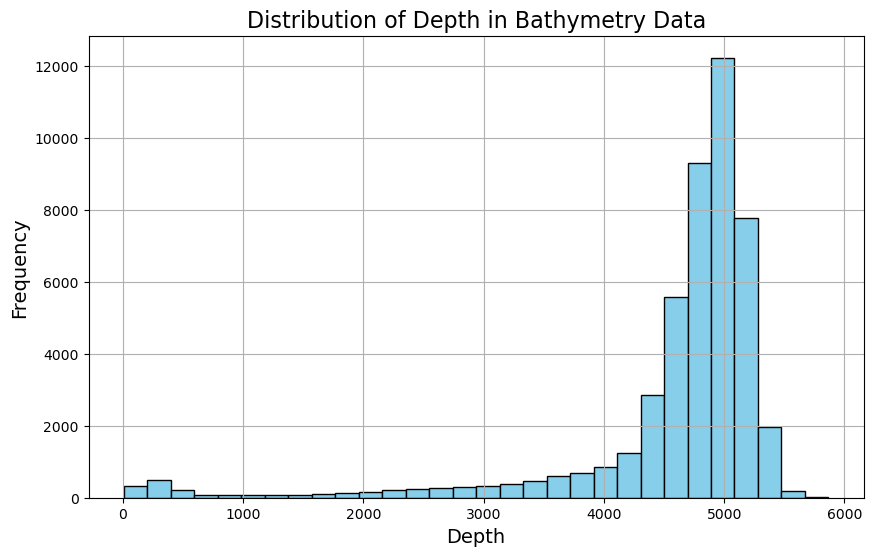

In [162]:
# Create a histogram of the Longitude distribution
nan_count = bathymetry_data['Depth'].isna().sum()

print(f"Number of NaN values in 'Depth' column: {nan_count}")
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(bathymetry_data['Depth'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
ax.set_xlabel('Depth', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of Depth in Bathymetry Data', fontsize=16)

# Show the plot
plt.grid(True)
plt.show()

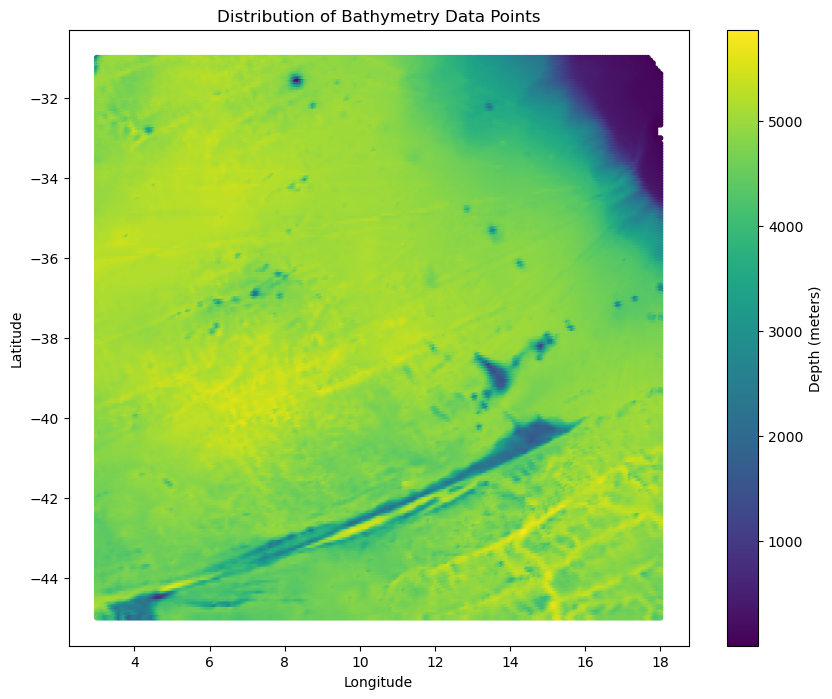

In [163]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(bathymetry_data['Longitude'], bathymetry_data['Latitude'], c=bathymetry_data['Depth'], cmap='viridis', s=10)
plt.colorbar(label='Depth (meters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Bathymetry Data Points')
plt.show()

In [164]:
# import the profiles with event 
# add the cycle number to the ecopart dataset 
ecopart = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/Ecopart_diagnostics_data_655.tsv', sep = '\t')

# Filter rows where the 'Profile' column contains the letter 'a'
ecopart = ecopart[ecopart['Profile'].str.contains('a', na=False)]
ecopart = ecopart[['Profile', 'Date_Time', 'Pressure [dbar]', 'MaP_abun', 'Map_POC_cont_mgC_m3', 'MiP_abun', 'Mip_POC_cont_mgC_m3']]
ecopart['Date_Time'] = pd.to_datetime(ecopart['Date_Time']).dt.strftime('%Y-%m-%d %H:%M:%S')

conditions = (
    ((ecopart['Date_Time'] >= '2021-10-08') & (ecopart['Date_Time'] <= '2021-10-23')) |
    ((ecopart['Date_Time'] >= '2021-11-25') & (ecopart['Date_Time'] <= '2021-12-22')) |
    ((ecopart['Date_Time'] >= '2022-03-10') & (ecopart['Date_Time'] <= '2022-04-15'))
)

prof_dat = ecopart[['Profile', 'Date_Time']]

float_pos = pd.merge(float_pos, prof_dat, on = 'Profile')
# Filter the DataFrame
event_df = ecopart[conditions]

event_profiles = sorted(event_df['Profile'].unique())
MaP_profiles = pd.DataFrame()
MaP_profiles['Profile'] = event_profiles
MaP_profiles = pd.merge(MaP_profiles, float_pos, on = 'Profile')
MaP_profiles = MaP_profiles.drop_duplicates()
MaP_profiles

,Profile,Latitude,Longitude,Profile_nb,Date_Time
0,0064a_WMO6903095,-37.605833,8.624722,65,2021-10-08 21:27:38
123,0065a_WMO6903095,-37.678611,7.644722,66,2021-10-11 19:52:24
324,0066a_WMO6903095,-36.635833,6.926389,67,2021-10-14 21:27:38
447,0067a_WMO6903095,-36.275278,7.790556,68,2021-10-17 19:52:25
644,0068a_WMO6903095,-37.008889,8.240278,69,2021-10-20 21:27:38
766,0080a_WMO6903095,-40.473889,9.478056,81,2021-11-25 21:27:38
888,0081a_WMO6903095,-39.658056,10.186667,82,2021-11-28 19:52:23
1086,0082a_WMO6903095,-38.906944,11.020833,83,2021-12-01 21:27:38
1211,0083a_WMO6903095,-38.981111,11.666944,84,2021-12-04 19:52:49
1409,0084a_WMO6903095,-39.112222,11.620556,85,2021-12-07 15:54:17


In [165]:
# import profiles with ESP events (as in Llort et al., 2018)
ESP_profiles = pd.DataFrame()
ESP_profiles['Profile'] = ['0053a_WMO6903095', '0083a_WMO6903095', '0085a_WMO6903095',
 '0087a_WMO6903095', '0089a_WMO6903095', '0097a_WMO6903095',
 '0098a_WMO6903095', '0099a_WMO6903095', '0102a_WMO6903095',
 '0103a_WMO6903095', '0104a_WMO6903095', '0105a_WMO6903095',
 '0106a_WMO6903095', '0110a_WMO6903095', '0113a_WMO6903095',
 '0117a_WMO6903095', '0119a_WMO6903095', '0121a_WMO6903095',
 '0127a_WMO6903095', '0131a_WMO6903095', '0132a_WMO6903095',
 '0133a_WMO6903095', '0134a_WMO6903095', '0136a_WMO6903095',
 '0137a_WMO6903095', '0138a_WMO6903095', '0142a_WMO6903095',
 '0143a_WMO6903095']

ESP_profiles = pd.merge(ESP_profiles, float_pos, on = 'Profile')
ESP_profiles = ESP_profiles.drop_duplicates()
ESP_profiles

,Profile,Latitude,Longitude,Profile_nb,Date_Time
0,0053a_WMO6903095,-35.441389,7.418889,54,2021-09-05 19:52:23
201,0083a_WMO6903095,-38.981111,11.666944,84,2021-12-04 19:52:49
399,0085a_WMO6903095,-39.061389,11.628611,86,2021-12-10 19:52:53
601,0087a_WMO6903095,-39.492778,10.200833,88,2021-12-16 21:03:49
744,0089a_WMO6903095,-39.232500,9.657222,90,2021-12-22 21:03:50
887,0097a_WMO6903095,-42.708333,11.819444,98,2022-01-15 21:03:48
1032,0098a_WMO6903095,-42.861667,11.832222,99,2022-01-18 21:03:49
1170,0099a_WMO6903095,-43.058056,12.013056,100,2022-01-21 21:03:49
1308,0102a_WMO6903095,-43.035833,11.852500,103,2022-01-30 19:52:52
1506,0103a_WMO6903095,-42.956111,11.711944,104,2022-02-02 19:52:53


In [166]:
esp_prof_list = ESP_profiles['Profile'].unique()
map_prof_list = MaP_profiles['Profile'].unique()
combined_prof_list = list(set(esp_prof_list) | set(map_prof_list))

all_other = float_pos[~float_pos['Profile'].isin(combined_prof_list)]

all_other = all_other.drop_duplicates()
all_other

,Profile,Latitude,Longitude,Profile_nb,Date_Time
0,0000a_WMO6903095,-33.070000,13.894444,1,2021-04-13 14:01:29
86,0001a_WMO6903095,-33.051944,13.943056,2,2021-04-13 20:03:06
153,0002a_WMO6903095,-33.040556,14.000833,3,2021-04-14 01:50:56
217,0003a_WMO6903095,-33.047778,14.058889,4,2021-04-14 07:32:27
280,0004a_WMO6903095,-33.064722,14.103056,5,2021-04-14 13:18:31
...,...,...,...,...,...
31539,0179a_WMO6903095,-34.176389,11.428056,180,2022-09-13 19:52:18
31743,0180a_WMO6903095,-34.191667,11.068056,181,2022-09-14 19:52:18
31943,0181a_WMO6903095,-34.246944,10.725556,182,2022-09-15 19:52:18
32145,0182a_WMO6903095,-34.339444,10.433333,183,2022-09-16 19:52:18


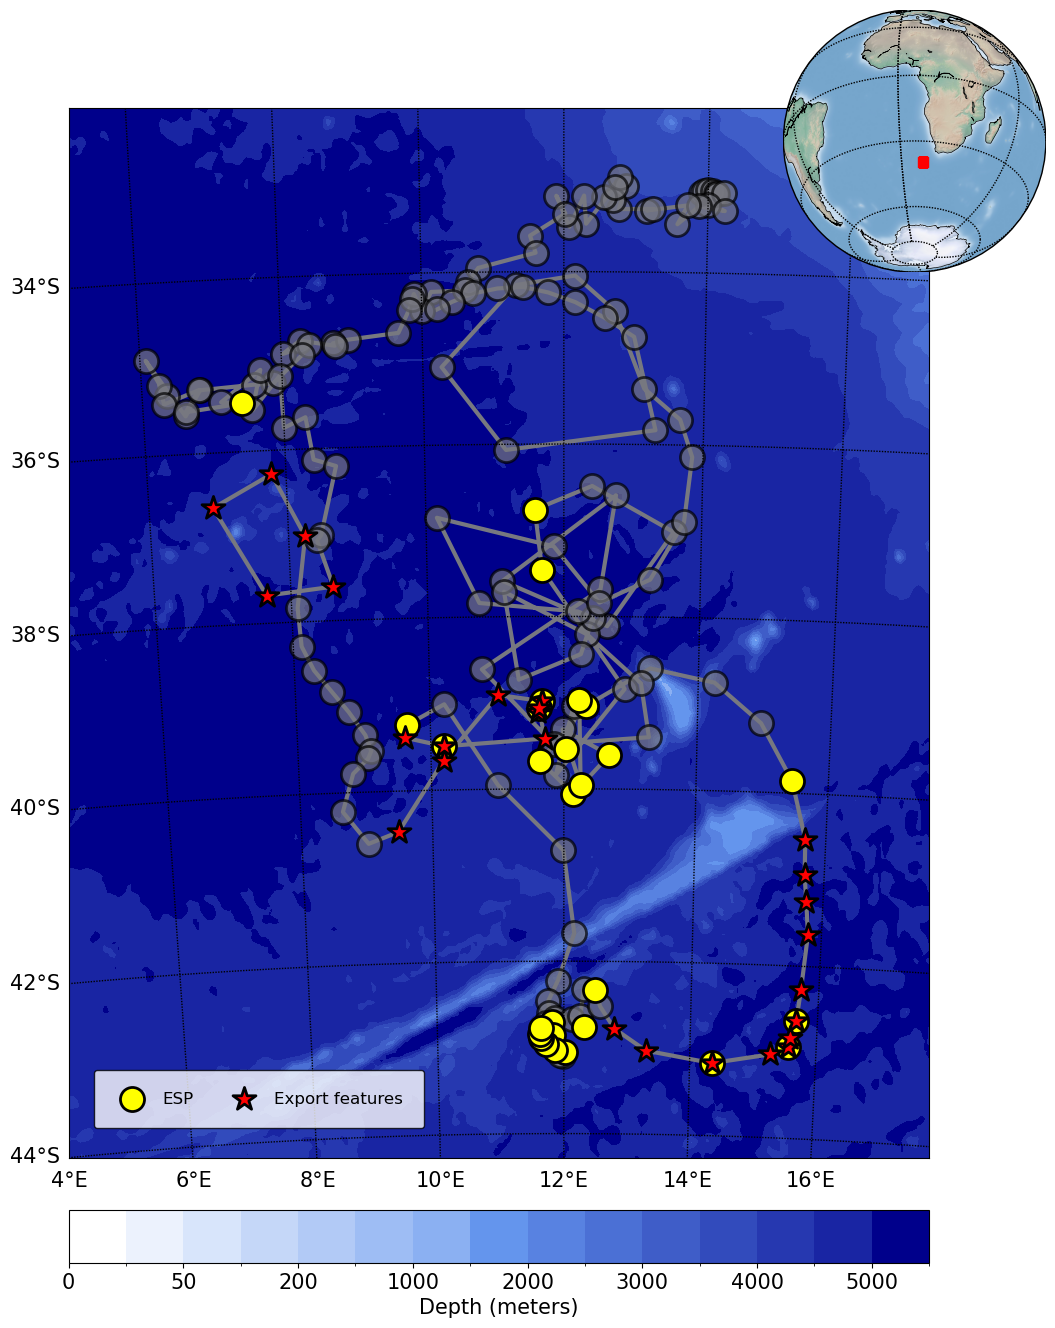

In [46]:
# Function to create a custom diverging colormap
def custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue', maxcol='w'):
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [mincol, midcol, maxcol], N)
    return cmap


# Create a grid for the bathymetry data
lon = np.linspace(bathymetry_data['Longitude'].min(), bathymetry_data['Longitude'].max(), 500)
lat = np.linspace(bathymetry_data['Latitude'].min(), bathymetry_data['Latitude'].max(), 500)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Interpolate the Depth values over the grid
depth_grid = griddata(
    (bathymetry_data['Longitude'], bathymetry_data['Latitude']),
    bathymetry_data['Depth'],
    (lon_grid, lat_grid),
    method='linear'
)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Initialize the basemap
m = Basemap(llcrnrlon=4, llcrnrlat=-44, urcrnrlon=17, urcrnrlat=-32,
            resolution='i', projection='cass', lon_0=12, lat_0=-39)

# Convert the lon and lat to map coordinates
x, y = m(lon_grid, lat_grid)

# Define custom color levels and colormap
blevels = [0, 25, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000]
#blevels = [-5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, -200, -100, 0]
N = len(blevels)  # Adjust N to match the number of boundaries

cmap2 = custom_div_cmap(N + 1, mincol='w', midcol='CornflowerBlue', maxcol='DarkBlue')  # Increase N by 1
cmap2.set_over('0.7')  # light gray

# Normalize the levels
norm = BoundaryNorm(blevels, ncolors=cmap2.N)

# Plot the bathymetry data as a contour plot
cs = m.contourf(x, y, depth_grid, levels=blevels, cmap=cmap2, norm=norm)

# Add a colorbar for the bathymetry at the bottom
cbar = m.colorbar(cs, location='bottom', pad="5%", extend='both', ax=ax)
cbar.set_label('Depth (meters)', size=15)
cbar.ax.tick_params(labelsize=15, axis='both')


# Create a color map for stations (though we'll use different markers here)

# for MaP events 
MaP_prof = MaP_profiles['Profile'].unique()
markers_MaP = ['*']
marker_map_MaP = {station: markers_MaP[i % len(markers_MaP)] for i, station in enumerate(MaP_prof)}

# for esp events 
ESP_prof = ESP_profiles['Profile'].unique()
markers_ESP = ['o']
marker_map_ESP = {station: markers_ESP[i % len(markers_ESP)] for i, station in enumerate(ESP_prof)}

# for all other profiles 
all_other_prof = filtered_float_pos['Profile'].unique()
markers_all = ['o']
marker_map_all = {station: markers_all[i % len(markers_all)] for i, station in enumerate(all_other_prof)}

# Draw lines connecting consecutive profiles for the trajectory
# Assuming `float_pos` is sorted by time or deployment order, or we can sort it based on a timestamp column.
sorted_float_pos = float_pos.sort_values(by='Profile')  # Adjust sorting criteria if needed
trajectory_lons = sorted_float_pos['Longitude'].values
trajectory_lats = sorted_float_pos['Latitude'].values
x_traj, y_traj = m(trajectory_lons, trajectory_lats)

# Plot the trajectory line with lower zorder to ensure it is in the background
m.plot(x_traj, y_traj, color='#777880', linestyle='-', linewidth=3, zorder=1)

# Plot each point with the corresponding marker and higher zorder
for station in all_other_prof:
    subset = float_pos[float_pos['Profile'] == station]
    lons = subset['Longitude']
    lats = subset['Latitude']
    x, y = m(lons.values, lats.values)
    m.scatter(x, y, 300, marker=marker_map_all[station], alpha = 0.7, label='', c='#777880', edgecolors='black', linewidths=2, zorder=2)

# For ESP profiles, add only the first plot with a label
for i, station in enumerate(ESP_prof):
    subset = float_pos[float_pos['Profile'] == station]
    lons = subset['Longitude']
    lats = subset['Latitude']
    x, y = m(lons.values, lats.values)
    label = 'ESP' if i == 0 else ''  # Only label the first plot
    m.scatter(x, y, 300, marker=marker_map_ESP[station], label=label, c='yellow', edgecolors='black', linewidths=2, zorder=3)

# For MaP profiles, add only the first plot with a label
for i, station in enumerate(MaP_prof):
    subset = float_pos[float_pos['Profile'] == station]
    lons = subset['Longitude']
    lats = subset['Latitude']
    x, y = m(lons.values, lats.values)
    label = 'Export features' if i == 0 else ''  # Only label the first plot
    m.scatter(x, y, 300, marker=marker_map_MaP[station], label=label, c='red', edgecolors='black', linewidths=2, zorder=4)


# Draw parallels and meridians with larger tick labels
parallels = np.arange(-44, -32, 2)
meridians = np.arange(4, 17, 2)

m.drawparallels(parallels, labels=[True, False, True, False], fontsize=15)
m.drawmeridians(meridians, labels=[False, False, False, True], fontsize=15)
#m.drawmapboundary(fill_color='#2b8cbe')

# Add legend
legend = plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), fontsize=12, ncol=2, borderpad=1.3)

# Increase the frame around the legend
legend.get_frame().set_linewidth(1)  # Adjust the linewidth of the legend frame
legend.get_frame().set_edgecolor('black')  # Set the edge color of the legend frame
legend.get_frame().set_facecolor('white')

plt.title("", fontsize=18)


# Create inset for the first map
ax_inset = inset_axes(ax, width="25%", height="25%", 
                      bbox_to_anchor=(0.1, 0.1, 7, 1), 
                      bbox_transform=ax.transAxes, loc=2)

# Plot the first map in the inset
lon_benguela, lat_benguela = 12, -39
m_inset = Basemap(projection='ortho', lon_0=7.314808, lat_0=-30, resolution='c', ax=ax_inset)
m_inset.drawcoastlines(linewidth=0.5)
m_inset.drawparallels(np.arange(-90., 120., 30.))
m_inset.drawmeridians(np.arange(0., 420., 60.))
m_inset.shadedrelief()
xpt_benguela, ypt_benguela = m_inset(lon_benguela, lat_benguela)
m_inset.scatter(xpt_benguela, ypt_benguela, 50, marker='s', c='red')

plt.savefig('/home/aaccardo/Accardo_et_al/Figures/Map/Benguela_ESP_map.png', dpi = 300)
plt.show()

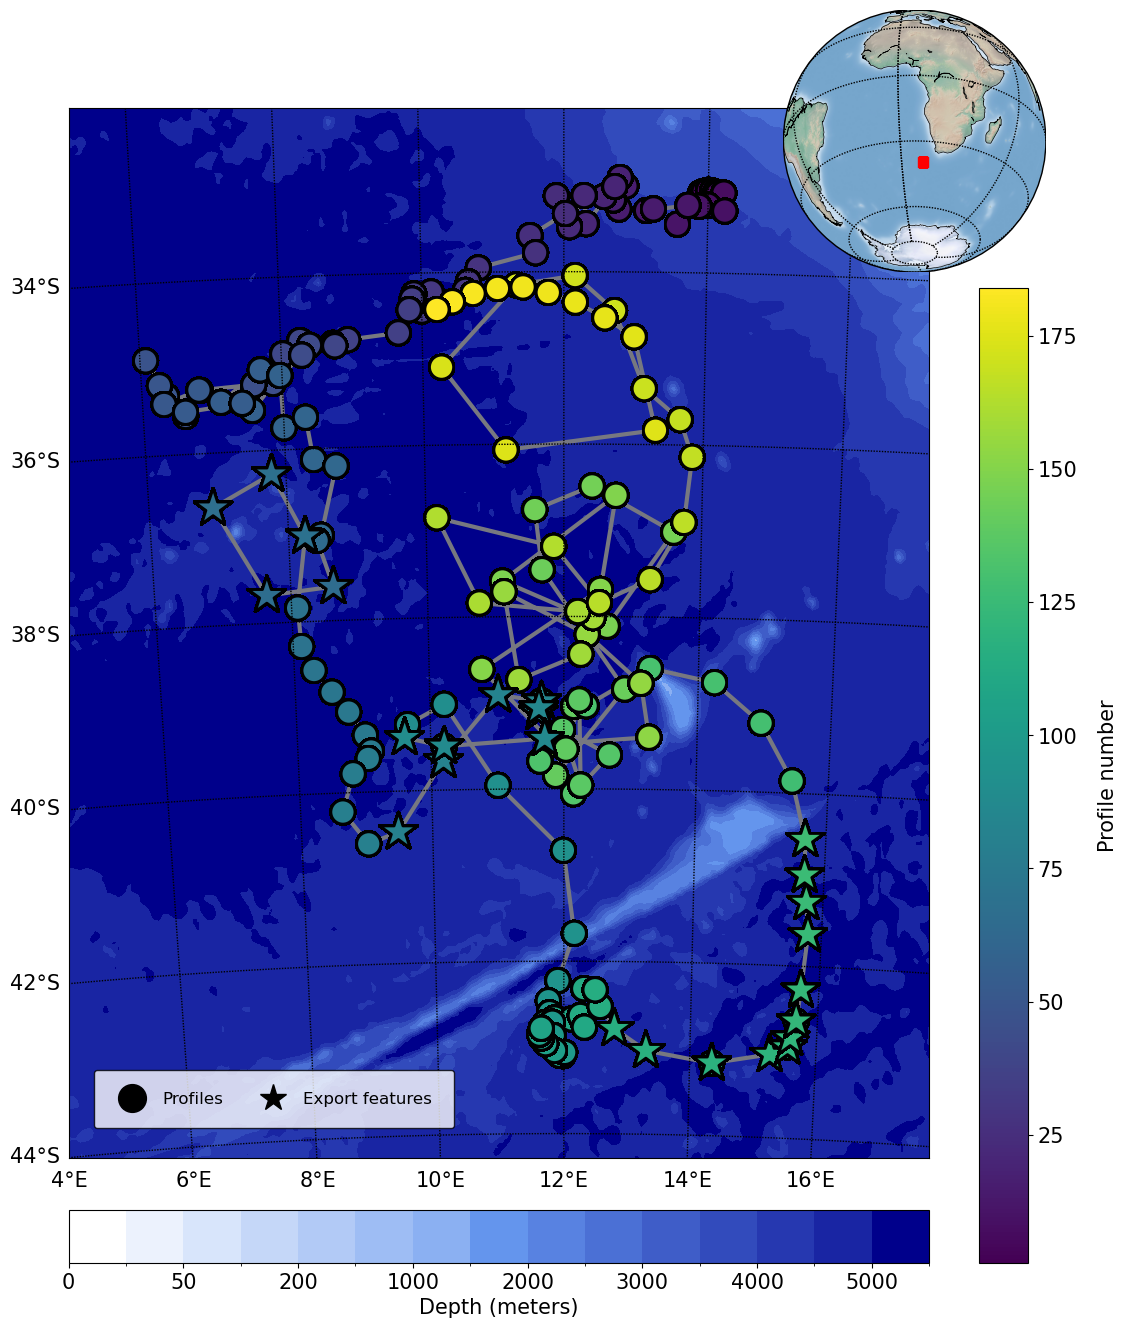

In [175]:
# Function to create a custom diverging colormap
def custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue', maxcol='w'):
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [mincol, midcol, maxcol], N)
    return cmap


# Create a grid for the bathymetry data
lon = np.linspace(bathymetry_data['Longitude'].min(), bathymetry_data['Longitude'].max(), 500)
lat = np.linspace(bathymetry_data['Latitude'].min(), bathymetry_data['Latitude'].max(), 500)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Interpolate the Depth values over the grid
depth_grid = griddata(
    (bathymetry_data['Longitude'], bathymetry_data['Latitude']),
    bathymetry_data['Depth'],
    (lon_grid, lat_grid),
    method='linear'
)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Initialize the basemap
m = Basemap(llcrnrlon=4, llcrnrlat=-44, urcrnrlon=17, urcrnrlat=-32,
            resolution='i', projection='cass', lon_0=12, lat_0=-39)

# Convert the lon and lat to map coordinates
x, y = m(lon_grid, lat_grid)

# Define custom color levels and colormap
blevels = [0, 25, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000]
#blevels = [-5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, -200, -100, 0]
N = len(blevels)  # Adjust N to match the number of boundaries

cmap2 = custom_div_cmap(N + 1, mincol='w', midcol='CornflowerBlue', maxcol='DarkBlue')  # Increase N by 1
cmap2.set_over('0.7')  # light gray

# Normalize the levels
norm = BoundaryNorm(blevels, ncolors=cmap2.N)

# Plot the bathymetry data as a contour plot
cs = m.contourf(x, y, depth_grid, levels=blevels, cmap=cmap2, norm=norm)

# Add a colorbar for the bathymetry at the bottom
cbar = m.colorbar(cs, location='bottom', pad="5%", extend='both', ax=ax)
cbar.set_label('Depth (meters)', size=15)
cbar.ax.tick_params(labelsize=15, axis='both')


# Create a color map for stations (though we'll use different markers here)

# for MaP events 
MaP_prof = MaP_profiles['Profile'].unique()
markers_MaP = ['*']
marker_map_MaP = {station: markers_MaP[i % len(markers_MaP)] for i, station in enumerate(MaP_prof)}

# for esp events 
ESP_prof = ESP_profiles['Profile'].unique()
markers_ESP = ['o']
marker_map_ESP = {station: markers_ESP[i % len(markers_ESP)] for i, station in enumerate(ESP_prof)}

# for all other profiles 
all_other_prof = filtered_float_pos['Profile'].unique()
markers_all = ['o']
marker_map_all = {station: markers_all[i % len(markers_all)] for i, station in enumerate(all_other_prof)}




# Determine the min and max of the timestamps for color normalization
min_timestamp = float_pos['Profile_nb'].min()
max_timestamp = float_pos['Profile_nb'].max()

# Normalize the colors across all points
norm = mcolors.Normalize(vmin=min_timestamp, vmax=max_timestamp)
cmap = plt.cm.viridis  # Choose a colormap, e.g., 'viridis'

# Draw lines connecting consecutive profiles for the trajectory
# Assuming `float_pos` is sorted by time or deployment order, or we can sort it based on a timestamp column.
sorted_float_pos = float_pos.sort_values(by='Profile')  # Adjust sorting criteria if needed
trajectory_lons = sorted_float_pos['Longitude'].values
trajectory_lats = sorted_float_pos['Latitude'].values
x_traj, y_traj = m(trajectory_lons, trajectory_lats)

# Plot the trajectory line with lower zorder to ensure it is in the background
m.plot(x_traj, y_traj, color='#777880', linestyle='-', linewidth=3, zorder=1)

# Plot each point with the corresponding marker and higher zorder
for i, station in enumerate(all_other_prof):
    subset = float_pos[float_pos['Profile'] == station]
    lons = subset['Longitude']
    lats = subset['Latitude']
    timestamps = subset['Profile_nb'].values
    #print(timestamps)
    x, y = m(lons.values, lats.values)
    label = 'Profiles' if i == 0 else ''
    m.scatter(x, y, 300, marker=marker_map_all[station], label = label, c = timestamps, edgecolors='black', linewidths=2, zorder=2, cmap=cmap, norm=norm)

# For ESP profiles, add only the first plot with a label
for i, station in enumerate(ESP_prof):
    subset = float_pos[float_pos['Profile'] == station]
    lons = subset['Longitude']
    
    lats = subset['Latitude']

    timestamps = subset['Profile_nb'].values
    #print(timestamps)
    x, y = m(lons.values, lats.values)
    label = 'ESP' if i == 0 else ''  # Only label the first plot
    m.scatter(x, y, 300, marker=marker_map_ESP[station], c=timestamps, edgecolors='black', linewidths=2, zorder=3, cmap=cmap, norm=norm)

# For MaP profiles, add only the first plot with a label
for i, station in enumerate(MaP_prof):
    subset = float_pos[float_pos['Profile'] == station]
    lons = subset['Longitude']

    lats = subset['Latitude']

    timestamps = subset['Profile_nb'].values
    #print(timestamps)
    x, y = m(lons.values, lats.values)
    label = 'Export features' if i == 0 else ''  # Only label the first plot
    m.scatter(x, y, 800, marker=marker_map_MaP[station], label=label, c=timestamps, edgecolors='black', linewidths=2, zorder=4, cmap=cmap, norm=norm)

# Add a shared colorbar for the scatter plots
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # We do not need data here, just for the colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')#, pad=0.015)
cbar.ax.set_position([0.675, 0.11, 0.03, 0.65]) #[left, bottom, width, height]
cbar.ax.yaxis.set_label_position('right')
cbar.set_label('Profile number', size=15, labelpad=15)
cbar.ax.tick_params(labelsize=15)

# Draw parallels and meridians with larger tick labels
parallels = np.arange(-44, -32, 2)
meridians = np.arange(4, 17, 2)

m.drawparallels(parallels, labels=[True, False, True, False], fontsize=15)
m.drawmeridians(meridians, labels=[False, False, False, True], fontsize=15)
#m.drawmapboundary(fill_color='#2b8cbe')

# Add legend
export_feature_marker = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=20, label='Export features')
profile_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=20, label='Profiles')

# Add legend with black markers
legend = ax.legend(handles=[profile_marker, export_feature_marker],
                   loc='lower left', bbox_to_anchor=(0.02, 0.02), fontsize=12, ncol=2, borderpad=1.3)

# Customize legend frame and appearance
legend.get_frame().set_linewidth(1)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('white')

plt.title("", fontsize=18)


# Create inset for the first map
ax_inset = inset_axes(ax, width="25%", height="25%", 
                      bbox_to_anchor=(0.1, 0.1, 7, 1), 
                      bbox_transform=ax.transAxes, loc=2)

# Plot the first map in the inset
lon_benguela, lat_benguela = 12, -39
m_inset = Basemap(projection='ortho', lon_0=7.314808, lat_0=-30, resolution='c', ax=ax_inset)
m_inset.drawcoastlines(linewidth=0.5)
m_inset.drawparallels(np.arange(-90., 120., 30.))
m_inset.drawmeridians(np.arange(0., 420., 60.))
m_inset.shadedrelief()
xpt_benguela, ypt_benguela = m_inset(lon_benguela, lat_benguela)
m_inset.scatter(xpt_benguela, ypt_benguela, 50, marker='s', c='red')

plt.savefig('/home/aaccardo/Accardo_et_al/Figures/Map/Benguela_float_map_fig_1.png', dpi = 300)

plt.show()

In [9]:
np.any(np.isnan(bathymetry_data))

False

In [10]:
norm

In [11]:
xllcorner

3.0

In [12]:
yllcorner

-48.0

In [13]:
cellsize

0.004166666667

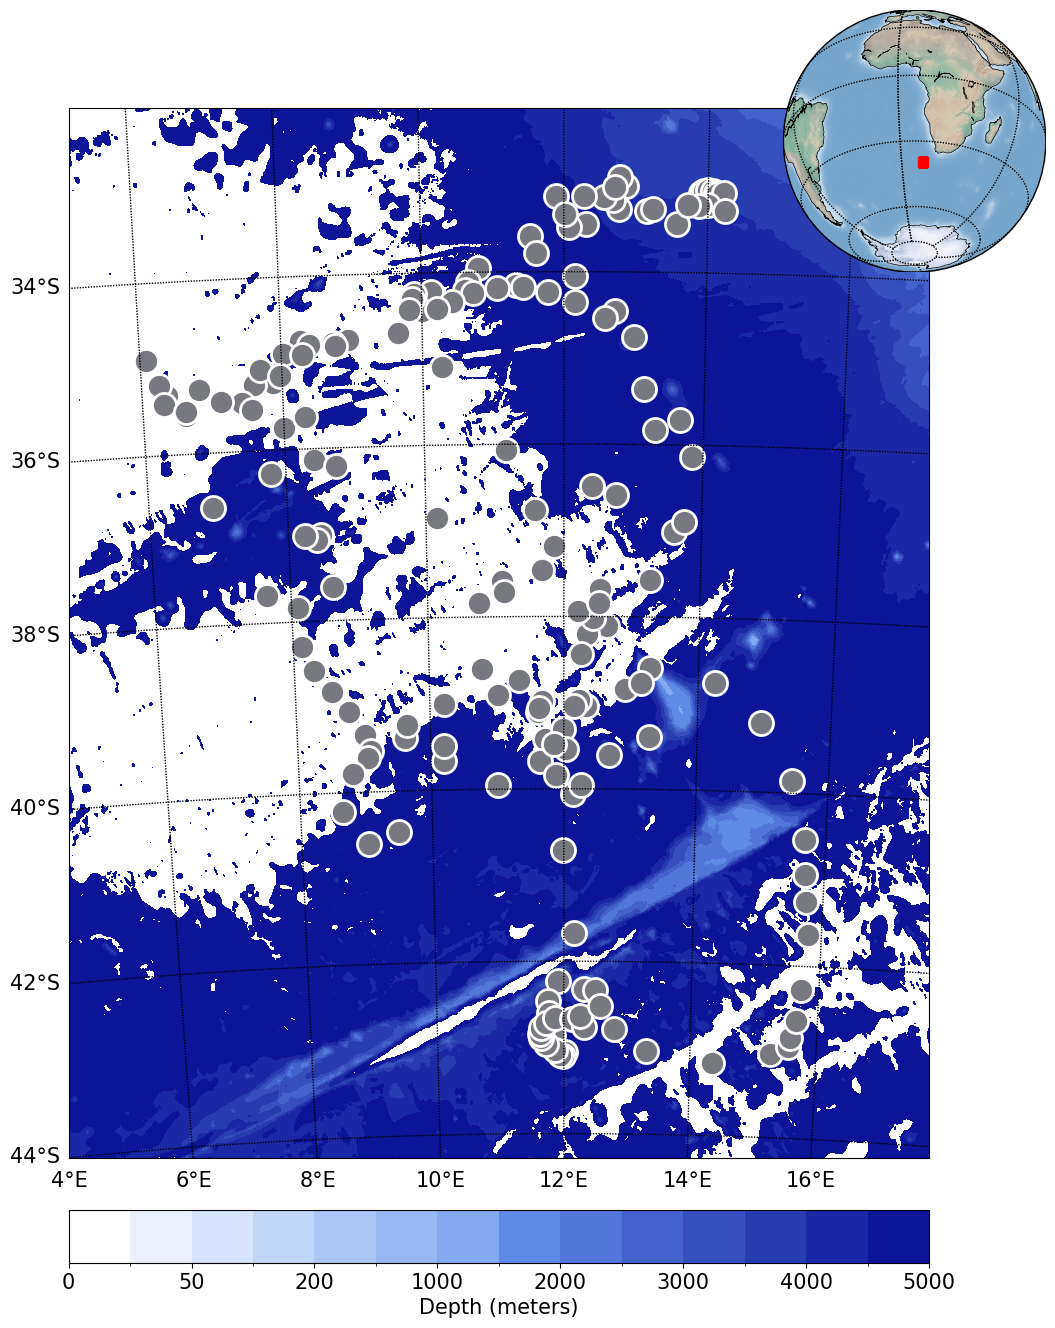

In [23]:
# Function to create a custom diverging colormap
def custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue', maxcol='w'):
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [mincol, midcol, maxcol], N)
    return cmap

# Create a list of markers
markers = ['o']

# Create a color map for stations (though we'll use different markers here)
unique_station = float_pos['Profile'].unique()
num_station = len(unique_station)
marker_map = {station: markers[i % len(markers)] for i, station in enumerate(unique_station)}

# Read the bathymetric data from the .asc file

bathymetry_file = '/home/aaccardo/Accardo_et_al/Data/map/gebco_2024_n-30.0_s-48.0_w3.0_e18.0.asc'
with open(bathymetry_file, 'r') as f:
    header = [next(f) for _ in range(6)]

ncols = int(header[0].split()[1])
nrows = int(header[1].split()[1])
xllcorner = float(header[2].split()[1])
yllcorner = float(header[3].split()[1])
cellsize = float(header[4].split()[1])
NODATA_value = float(header[5].split()[1])

# Read the data
bathymetry_data = np.loadtxt(bathymetry_file, skiprows=6)

# Replace no-data values with NaN
bathymetry_data[bathymetry_data == NODATA_value] = np.nan

# Create grid of original data
lon = np.linspace(xllcorner, xllcorner + cellsize * ncols, ncols)
lat = np.linspace(yllcorner, yllcorner + cellsize * nrows, nrows)
lat = lat[::-1]

lon_grid, lat_grid = np.meshgrid(lon, lat)

# Mask valid (non-NaN) values for interpolation
valid_mask = ~np.isnan(bathymetry_data)

# Extract coordinates of valid data points
valid_lon = lon_grid[valid_mask]
valid_lat = lat_grid[valid_mask]
valid_data = bathymetry_data[valid_mask]

# Define a linear interpolation method for NaN values
bathymetry_data_interpolated = griddata(
    (valid_lon, valid_lat), valid_data, (lon_grid, lat_grid), method='linear'
)

# If there are any remaining NaNs, you can choose to fill them with nearest neighbor interpolation
bathymetry_data_interpolated = griddata(
    (valid_lon, valid_lat), valid_data, (lon_grid, lat_grid), method='nearest'
)

# Multiply by -1 to ensure depths are positive
bathymetry_data_interpolated = -bathymetry_data_interpolated

# Now you can proceed to plot the interpolated data
fig, ax = plt.subplots(figsize=(20, 15))

# Initialize the basemap
m = Basemap(llcrnrlon=4, llcrnrlat=-44, urcrnrlon=17, urcrnrlat=-32,
            resolution='i', projection='cass', lon_0=12, lat_0=-39)

# Create the x, y coordinates for the map projection
x, y = m(lon_grid, lat_grid)

# Define custom color levels and colormap
blevels = [0, 25, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
N = len(blevels)

cmap2 = custom_div_cmap(N + 1, mincol='w', midcol='CornflowerBlue', maxcol='DarkBlue')
cmap2.set_over('0.7')

# Normalize the levels
norm = BoundaryNorm(blevels, ncolors=cmap2.N)

# Plot the interpolated bathymetry data
cs = m.contourf(x, y, bathymetry_data_interpolated, levels=blevels, cmap=cmap2, norm=norm)

# Add colorbar, stations, and other map elements as before
cbar = m.colorbar(cs, location='bottom', pad="5%", extend='both', ax=ax)
cbar.set_label('Depth (meters)', size=15)
cbar.ax.tick_params(labelsize=15, axis='both')

# Plot each station as before
for station in unique_station:
    subset = float_pos[float_pos['Profile'] == station]
    lons = subset['Longitude']
    lats = subset['Latitude']
    x, y = m(lons.values, lats.values)
    m.scatter(x, y, 300, marker=marker_map[station], label=station, c='#777880', edgecolors='white', linewidths=2)

# Draw parallels and meridians
parallels = np.arange(-44, -32, 2)
meridians = np.arange(4, 17, 2)
m.drawparallels(parallels, labels=[True, False, True, False], fontsize=15)
m.drawmeridians(meridians, labels=[False, False, False, True], fontsize=15)

plt.title("", fontsize=18)

# Create inset for the first map
ax_inset = inset_axes(ax, width="25%", height="25%", 
                      bbox_to_anchor=(0.1, 0.1, 7, 1), 
                      bbox_transform=ax.transAxes, loc=2)

# Plot the first map in the inset
lon_benguela, lat_benguela = 12, -39
m_inset = Basemap(projection='ortho', lon_0=7.314808, lat_0=-30, resolution='c', ax=ax_inset)
m_inset.drawcoastlines(linewidth=0.5)
m_inset.drawparallels(np.arange(-90., 120., 30.))
m_inset.drawmeridians(np.arange(0., 420., 60.))
m_inset.shadedrelief()
xpt_benguela, ypt_benguela = m_inset(lon_benguela, lat_benguela)
m_inset.scatter(xpt_benguela, ypt_benguela, 50, marker='s', c='red')

plt.show()

In [24]:
bathymetry_data_interpolated

array([[1364., 1380., 1391., ..., -570., -618., -625.],
       [1355., 1374., 1382., ..., -581., -577., -583.],
       [1349., 1374., 1374., ..., -613., -581., -593.],
       ...,
       [4422., 4425., 4427., ..., 4664., 4658., 4652.],
       [4422., 4425., 4427., ..., 4672., 4666., 4660.],
       [4421., 4424., 4427., ..., 4680., 4674., 4668.]])